In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/") 

In [140]:
from envs.windy_gridworld import WindyGridworldEnv
import plotting

import gym
import numpy as np
import itertools
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

## Windy Gridworld Playground环境介绍

- observation为格子所在的编号;
- action的组成: 有4个动作, 分别是上下左右;
    - 0, UP
    - 1, RIGHT
    - 2, DOWN
    - 3, LEFT
- reward: 每走一步reward=-1, reward越大也就是走的步数越少;
    

### 初始化环境

In [141]:
environment = WindyGridworldEnv()

In [142]:
# 这个环境中可能动作的个数
nA = environment.action_space.n
print(nA)

4


### 策略的定义

- $\mu$使用$\epsilon$-greedy策略
- $\pi$使用greedy策略

In [143]:
def mu_policy(Q, epsilon, nA):
    """
    这是一个随机的策略, 执行每一个action的概率都是相同的.
    """
    def policy_fn(observation):
        # 看到这个state之后, 采取不同action获得的累计奖励
        action_values = Q[observation]
        # 使用获得奖励最大的那个动作
        greedy_action = np.argmax(action_values)
        # 是的每个动作都有出现的可能性
        probabilities = np.ones(nA) /nA * epsilon
        # 最好的那个动作的概率会大一些
        probabilities[greedy_action] = probabilities[greedy_action] + (1 - epsilon)
        
        return probabilities

    return policy_fn

In [144]:
def pi_policy(Q):
    """
    这是greedy policy, 每次选择最优的动作
    """
    def policy_fn(observation):
        action_values = Q[observation]
        best_action = np.argmax(action_values) # 选择最优的动作
        return np.eye(len(action_values))[best_action] # 返回的是两个动作出现的概率
        
    return policy_fn

### Importance Sampling for Off-Policy MC

In [145]:
def mc_control_importance_sampling(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.2):   
    # 环境中所有动作的数量
    nA = env.action_space.n

    # 初始化Q表
    Q = defaultdict(lambda: np.zeros(nA))

    # importance sampling的累计分母
    C = defaultdict(lambda: np.zeros(nA))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes+1),
        episode_rewards=np.zeros(num_episodes+1)) 
    
    # Our greedily policy we want to learn
    policy = pi_policy(Q) # 这个是我们要更新的策略, 这个是greedy的
    behavior_policy = mu_policy(Q, epsilon, nA) # 这是我们实际执行action时候采取的策略,
        
    for i_episode in range(1, num_episodes + 1):
        episode = []
        state = env.reset()
        for t in range(100): # 最多走100步
            # Sample an action from our policy
            action = np.random.choice(nA, p=behavior_policy(state))
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

            # 进行统计
            stats.episode_rewards[i_episode] += reward # 计算累计奖励
            stats.episode_lengths[i_episode] = t # 查看每一轮的时间

        if i_episode % 100 == 0:
            # 打印
            print("\rEpisode {}/{}. | ".format(i_episode, num_episodes), end="")
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]: # 倒着来计算, 这样G好计算
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            Q[state][action] = Q[state][action] + alpha*(W*G - Q[state][action])
            W = W * 1./behavior_policy(state)[action]

            if action !=  np.argmax(policy(state)): # 一旦不相等, 就会分子为0
                break
            
    return Q, policy, stats

### 开始模拟

In [146]:
Q, policy, stats = mc_control_importance_sampling(environment, num_episodes=10000, discount_factor=0.9, alpha=0.2, epsilon=0.2)

Episode 10000/10000. | 

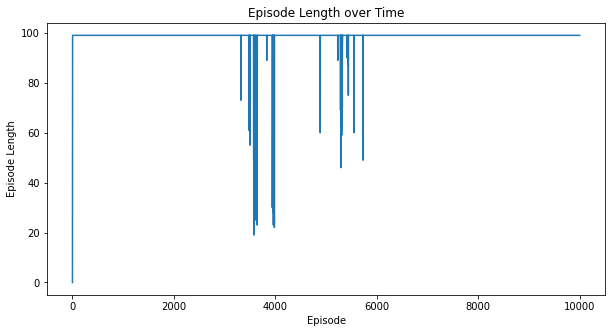

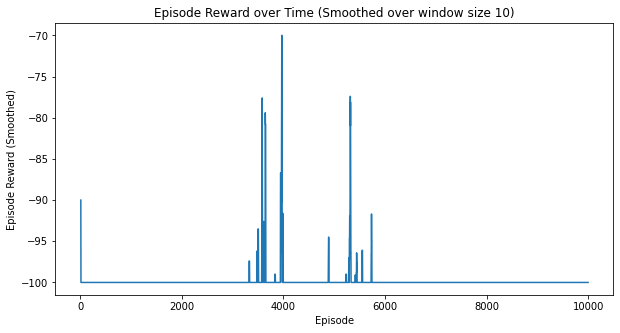

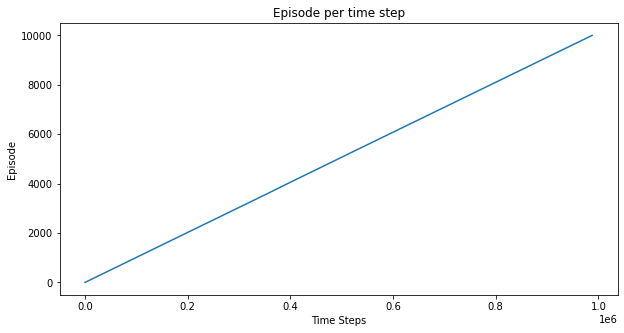

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [147]:
plotting.plot_episode_stats(stats)

### 使用最终策略执行

In [148]:
state = environment.reset()
action = np.argmax(policy(state))

for t in itertools.count():
    state, reward, done, _ = environment.step(action) # 执行action, 返回reward和下一步的状态 
    action = np.argmax(policy(state)) # 查看新的action

    print('-Step:{}-'.format(str(t)))
    environment._render() # 显示结果

    if done:
        break

    if t > 50:
        break

-Step:0-
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:1-
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:2-
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:3-
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

-Step:4-
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o 